<a href="https://colab.research.google.com/github/SRIJAA12/terrain_classification/blob/main/terrain_classifier_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow matplotlib scikit-learn tensorflow-datasets

# --- IMPORTS ---
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from collections import Counter
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_datasets as tfds

In [ ]:
# Load EuroSAT RGB dataset
dataset, info = tfds.load("eurosat/rgb", with_info=True, as_supervised=True,
                          split=["train[:80%]", "train[80%:]"])

train_ds, val_ds = dataset
class_names = info.features["label"].names
NUM_CLASSES = info.features["label"].num_classes

print("✅ Dataset Loaded!")
print("📊 Number of Classes:", NUM_CLASSES)
print("🏷️ Class Names:", class_names)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.GQXGXG_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
✅ Dataset Loaded!
📊 Number of Classes: 10
🏷️ Class Names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
# Constants
IMG_SIZE = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Preprocessing: resize + normalize
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

# Data augmentation block
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])


In [ ]:
# Apply preprocess and augmentations
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

# Batch and prefetch
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("🛠️ Preprocessing & Augmentation done.")


🛠️ Preprocessing & Augmentation done.


In [ ]:
# Load MobileNetV2 base
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True  # Fine-tune enabled

# Freeze early layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 2,026,698 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
# Optional: Class weights to handle imbalance
label_list = [label.numpy() for _, label in train_ds.unbatch()]
class_counts = Counter(label_list)
total = sum(class_counts.values())
class_weights = {i: total / (len(class_counts) * class_counts[i]) for i in class_counts}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_terrain_model.keras', save_best_only=True)
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights  # only if using class weighting
)


print("🎉 Training Complete and model saved to Drive!")


Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 585s 860ms/step - accuracy: 0.3465 - loss: 1.6976 - val_accuracy: 0.7811 - val_loss: 0.6277
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 586s 806ms/step - accuracy: 0.3431 - loss: 1.7081 - val_accuracy: 0.7724 - val_loss: 0.6467
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 575s 844ms/step - accuracy: 0.3439 - loss: 1.7001 - val_accuracy: 0.7676 - val_loss: 0.6628
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 610s 828ms/step - accuracy: 0.3494 - loss: 1.7053 - val_accuracy: 0.7769 - val_loss: 0.6416
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 631s 839ms/step - accuracy: 0.3455 - loss: 1.7056 - val_accuracy: 0.7724 - val_loss: 0.6517
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 629s 852ms/step - accuracy: 0.3490 - loss: 1.6848 - val_accuracy: 0.7856 - val_loss: 0.6197
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 608s 829ms/step - accuracy: 0.3493 - loss: 1.6880 - val_accuracy: 0.7822 - val_loss: 0.6306
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 594s 789ms/step - accuracy: 0.3507 -

In [ ]:
# Run predictions
val_images, val_labels = next(iter(val_ds.unbatch().batch(16)))
pred_probs = model.predict(val_images)
pred_labels = tf.argmax(pred_probs, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


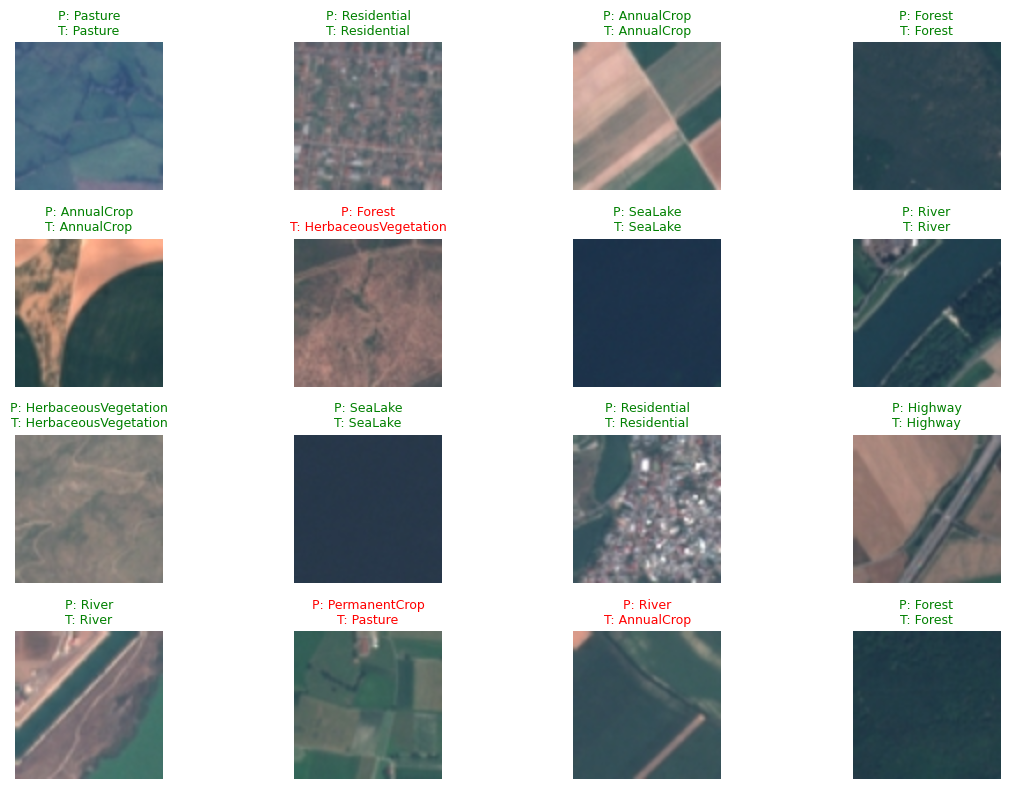

In [ ]:
# Plot predictions vs actual
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = val_images[i]
    true = class_names[val_labels[i].numpy()]
    pred = class_names[pred_labels[i].numpy()]
    color = "green" if true == pred else "red"
    plt.imshow(img)
    plt.title(f"P: {pred}\nT: {true}", color=color, fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# Smart messages per class
terrain_messages = {
    "AnnualCrop": "Crop field detected. Maintain medium altitude.",
    "Forest": "Stable zone. Expect calm wind.",
    "HerbaceousVegetation": "Open vegetation. Suitable for scanning.",
    "Highway": "Road detected. Maintain height and avoid vehicles.",
    "Industrial": "Caution: Obstructions likely. Maintain max altitude.",
    "Pasture": "Livestock zone. Maintain safe distance.",
    "PermanentCrop": "Orchard zone. Monitor tree height.",
    "Residential": "Urban zone. Avoid low flyovers.",
    "River": "Water detected. Be cautious of reflections.",
    "SeaLake": "Large water body. Ensure GPS lock."
}


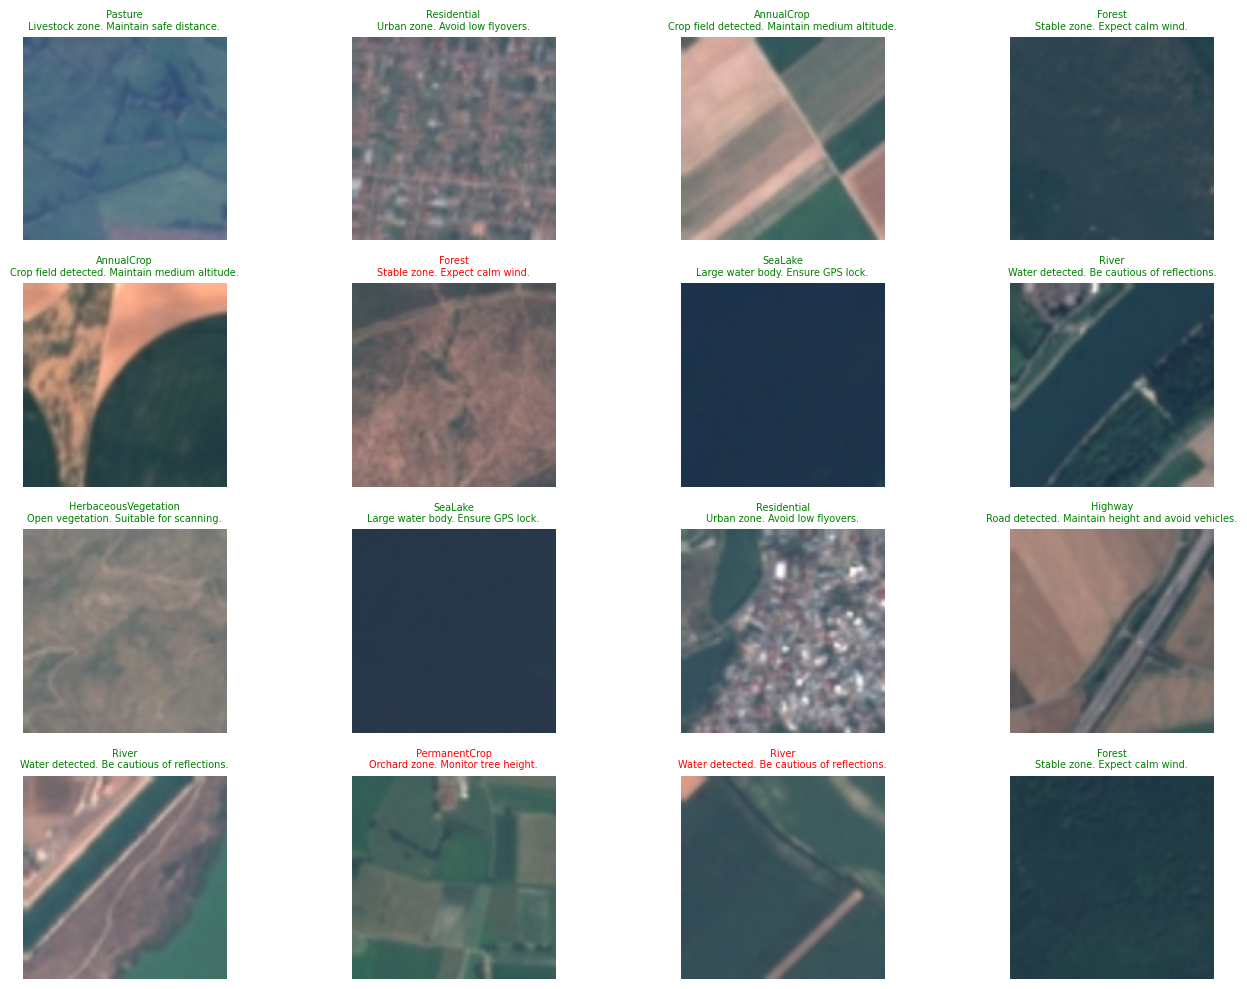

In [ ]:
# Visualize predictions with messages
plt.figure(figsize=(14, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = val_images[i]
    pred_idx = pred_labels[i].numpy()
    true_idx = val_labels[i].numpy()
    pred_class = class_names[pred_idx]
    true_class = class_names[true_idx]
    message = terrain_messages[pred_class]
    color = "green" if pred_class == true_class else "red"
    plt.imshow(img)
    plt.title(f"{pred_class}\n{message}", fontsize=7, color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save("/content/drive/MyDrive/best_terrain_model.keras")


In [ ]:
import zipfile

# Path to your model
model_path = "/content/drive/MyDrive/best_terrain_model.keras"
zip_path = "/content/drive/MyDrive/best_terrain_model.zip"

# Zip it
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(model_path, arcname="best_terrain_model.keras")

print("Model zipped successfully at:", zip_path)



Model zipped successfully at: /content/drive/MyDrive/best_terrain_model.zip
